# Face swapping local avec .venv (notebook)

Ce notebook est conçu pour être exécuté dans un environnement Python créé avec `python -m venv` (pas conda). Il aide à :
- vérifier que tu es bien dans un .venv
- installer les dépendances (hors torch) dans le .venv
- définir les chemins vers ton dossier `fsgan` cloné et vers les poids (.pth)
- initialiser l'objet `FaceSwapping` (si les poids existent)
- te montrer comment lancer l'inférence ou où trouver le script/méthode d'appel

Avant d'exécuter :
1. Crée et active ton .venv en dehors du notebook (terminal) :
   python3 -m venv ~/venv_fsgan
   source ~/venv_fsgan/bin/activate

2. Installe la bonne version de torch pour ta machine (exemples) :
   - CPU-only :
     python -m pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu
   - CUDA 11.7 (si tu as CUDA 11.7) :
     python -m pip install torch torchvision --index-url https://download.pytorch.org/whl/cu117

3. Lance Jupyter depuis le .venv :
   python -m pip install jupyter
   source ~/venv_fsgan/bin/activate
   jupyter notebook

4. Ouvre ce notebook dans Jupyter (toujours avec le .venv activé).

Remarque : adapte les variables REPO_ROOT et WEIGHTS_DIR dans la cellule `Configuration des chemins` plus bas.

In [1]:
import sys, os
print('Python executable:', sys.executable)
print('Python version:', sys.version)
in_venv = getattr(sys, 'base_prefix', None) != sys.prefix
print('Dans un venv:', in_venv)
print('\nChemins importants:')
print('sys.path[0]:', sys.path[0])


Python executable: c:\dev\ProjetImage\Face-Swap-M2\.venv\Scripts\python.exe
Python version: 3.10.4 (tags/v3.10.4:9d38120, Mar 23 2022, 23:13:41) [MSC v.1929 64 bit (AMD64)]
Dans un venv: True

Chemins importants:
sys.path[0]: C:\Python310\python310.zip


Cellule suivante : installe les dépendances Python (sauf torch). Le notebook utilisera `sys.executable -m pip` pour installer dans le .venv actif.

In [2]:
import subprocess, sys
reqs = ['opencv-python', 'ffmpeg-python', 'youtube-dl', 'yacs', 'tqdm', 'moviepy']
print('Installation (ou vérification) des dépendances:', reqs)
subprocess.check_call([sys.executable, '-m', 'pip', 'install', '--upgrade', 'pip'])
subprocess.check_call([sys.executable, '-m', 'pip', 'install'] + reqs)
print('Dépendances installées (hors torch).')

Installation (ou vérification) des dépendances: ['opencv-python', 'ffmpeg-python', 'youtube-dl', 'yacs', 'tqdm', 'moviepy']
Dépendances installées (hors torch).


In [12]:
import subprocess, sys

# Dépendances supplémentaires requises par fsgan
extra_deps = [
    'face_detection_dsfd',
    'face_alignment',
    'kornia',
    'scipy',
    'scikit-image',
    'pillow',
    'numpy'
]

print('Installation des dépendances supplémentaires pour fsgan:', extra_deps)
subprocess.check_call([sys.executable, '-m', 'pip', 'install'] + extra_deps)
print('Dépendances supplémentaires installées.')

Installation des dépendances supplémentaires pour fsgan: ['face_detection_dsfd', 'face_alignment', 'kornia', 'scipy', 'scikit-image', 'pillow', 'numpy']


CalledProcessError: Command '['c:\\dev\\ProjetImage\\Face-Swap-M2\\.venv\\Scripts\\python.exe', '-m', 'pip', 'install', 'face_detection_dsfd', 'face_alignment', 'kornia', 'scipy', 'scikit-image', 'pillow', 'numpy']' returned non-zero exit status 1.

Configuration des chemins. Modifie REPO_ROOT et WEIGHTS_DIR pour pointer vers ton clone `fsgan` et le dossier contenant les .pth.

In [3]:
# ========== ADAPTE CES CHEMINS AVANT D'EXÉCUTER ========== 
REPO_ROOT = 'fsgan/'        # ex: '/home/ton_user/projects/fsgan'
WEIGHTS_DIR = 'weights/'      # ex: '/home/ton_user/projects/fsgan_weights'
# ======================================================
print('REPO_ROOT =', REPO_ROOT)
print('WEIGHTS_DIR =', WEIGHTS_DIR)
print('\nContenu du dossier inference (si REPO_ROOT correct) :')
try:
    print('\n'.join(os.listdir(os.path.join(REPO_ROOT, 'inference'))))
except Exception as e:
    print('Impossible de lister inference/:', e)


REPO_ROOT = fsgan/
WEIGHTS_DIR = weights/

Contenu du dossier inference (si REPO_ROOT correct) :
face_swapping.ipynb
reenact.py
swap.py
__pycache__


Initialisation de fsgan : ajout du repo au PYTHONPATH, import des modules et vérification des poids. Si l'import de torch échoue, assure-toi d'avoir installé torch dans ton .venv (voir instructions plus haut).

In [5]:
import sys, os
if REPO_ROOT not in sys.path:
    sys.path.insert(0, REPO_ROOT)

missing = []
expected = [
    os.path.join(WEIGHTS_DIR, 'WIDERFace_DSFD_RES152.pth'),
    os.path.join(WEIGHTS_DIR, 'hopenet_robust_alpha1.pth'),
    os.path.join(WEIGHTS_DIR, 'hr18_wflw_landmarks.pth'),
    os.path.join(WEIGHTS_DIR, 'celeba_unet_256_1_2_segmentation_v2.pth'),
    os.path.join(WEIGHTS_DIR, 'nfv_msrunet_256_1_2_reenactment_v2.1.pth'),
    os.path.join(WEIGHTS_DIR, 'ijbc_msrunet_256_1_2_inpainting_v2.pth'),
    os.path.join(WEIGHTS_DIR, 'ijbc_msrunet_256_1_2_blending_v2.pth'),
    os.path.join(WEIGHTS_DIR, 'vggface2_vgg19_256_1_2_id.pth'),
]
for p in expected:
    if not os.path.exists(p):
        missing.append(p)

if missing:
    print('ATTENTION : fichiers de poids manquants :')
    for m in missing:
        print(' -', m)
    print('\nPlace les fichiers .pth requis dans WEIGHTS_DIR ou adapte la liste si tu possèdes d autres fichiers.')
else:
    print('Tous les fichiers de poids attendus semblent présents (vérifie les noms exacts si besoin).')

try:
    import torch
    print('Torch importé :', torch.__version__)
except Exception as e:
    print('Impossible d\'importer torch. Installe torch dans ton .venv avant de continuer. Erreur:', e)

try:
    from fsgan.inference.swap import FaceSwapping
    from fsgan.criterions.vgg_loss import VGGLoss
    print('\nImport fsgan réussi.')
except Exception as e:
    print('\nImpossible d\'importer fsgan depuis REPO_ROOT. Vérifie que REPO_ROOT est correct et que le dossier contient un package fsgan. Erreur:', e)


Tous les fichiers de poids attendus semblent présents (vérifie les noms exacts si besoin).
Torch importé : 2.9.1+cpu

Import fsgan réussi.


Initialisation de l'objet FaceSwapping (exemple). Si une erreur survient, lis le message et ajuste les chemins/versions. La cellule créée ci-dessous correspond aux noms de poids standards du dépôt — adapte si nécessaire.

In [16]:
try:
    import torch
    # Force tous les chargements de tensors sur CPU
    torch.set_default_device('cpu')
    device = torch.device('cpu')
    
    # Définit les chemins aux modèles
    detection_model = os.path.join(WEIGHTS_DIR, 'WIDERFace_DSFD_RES152.pth')
    pose_model = os.path.join(WEIGHTS_DIR, 'hopenet_robust_alpha1.pth')
    lms_model = os.path.join(WEIGHTS_DIR, 'hr18_wflw_landmarks.pth')
    seg_model = os.path.join(WEIGHTS_DIR, 'celeba_unet_256_1_2_segmentation_v2.pth')
    reenactment_model = os.path.join(WEIGHTS_DIR, 'nfv_msrunet_256_1_2_reenactment_v2.1.pth')
    completion_model = os.path.join(WEIGHTS_DIR, 'ijbc_msrunet_256_1_2_inpainting_v2.pth')
    blending_model = os.path.join(WEIGHTS_DIR, 'ijbc_msrunet_256_1_2_blending_v2.pth')
    criterion_id_path = os.path.join(WEIGHTS_DIR, 'vggface2_vgg19_256_1_2_id.pth')

    # Patch temporaire pour forcer le chargement sur CPU
    original_load = torch.load
    torch.load = lambda *args, **kwargs: original_load(*args, **{**kwargs, 'map_location': 'cpu'})
    
    criterion_id = VGGLoss(criterion_id_path)
    
    # Restaure torch.load
    torch.load = original_load

    print('VGGLoss initialisé avec succès sur CPU.')
except Exception as e:
    print('Erreur lors de l\'initialisation :', e)
    import traceback
    traceback.print_exc()

VGGLoss initialisé avec succès sur CPU.


Trouver et appeler la méthode d'inférence :
- Le dépôt fournit parfois un script CLI dans `inference/` et/ou une méthode sur l'objet FaceSwapping.
- La cellule suivante liste les fichiers dans `inference/` pour t'aider à repérer un script exécutable (par ex `face_swap.py` ou `swap.py`).

In [17]:
inference_dir = os.path.join(REPO_ROOT, 'inference')
if os.path.isdir(inference_dir):
    files = os.listdir(inference_dir)
    print('Fichiers dans inference/:')
    for f in files:
        print(' -', f)
    # Si existe, affiche le début d'un fichier swap.py pour retrouver la fonction
    candidate = os.path.join(inference_dir, 'swap.py')
    candidate2 = os.path.join(inference_dir, 'face_swap.py')
    for c in (candidate, candidate2):
        if os.path.exists(c):
            print('\n--- Début de', os.path.basename(c), '---')
            with open(c, 'r', encoding='utf-8', errors='ignore') as fh:
                for i, line in enumerate(fh):
                    print(line.rstrip())
                    if i > 200:
                        break
            break
else:
    print('Dossier inference/ introuvable : vérifie REPO_ROOT.')


Fichiers dans inference/:
 - face_swapping.ipynb
 - reenact.py
 - swap.py
 - __pycache__

--- Début de swap.py ---
""" Face swapping inference pipeline.

This script implements face swapping for both images and videos using an appearance map for the source subject.
The main pipeline components are: face reenactment and segmentation, inpainting, and blending.

Information about both source and target files will be extracted and cached in directories by the file's name without
the extension, residing in the same directory as the file. The information contains: face detections, face sequences,
and cropped videos per sequence. In addition for each cropped video, the corresponding pose, landmarks, and
segmentation masks will be computed and cached.
"""

import os
import argparse
import sys
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.

Exemple d'utilisation si le dépôt propose un script CLI (exécute dans le .venv, cell suivante exécute le script via subprocess) :
- Adapte `script_name` et les arguments selon le script présent.
- Si tu préfères appeler une méthode Python sur `face_swapping`, ouvre `fsgan/inference/swap.py` pour connaître l'API et adapte l'appel.

In [108]:
# Chemins des images'C:\\dev\\ProjetImage\\Face-Swap-M2\\data\\kirk.jpg'
source_path = 'C:\\dev\\ProjetImage\\Face-Swap-M2\\data\\kirk.jpg'
target_path = 'C:\\dev\\ProjetImage\\Face-Swap-M2\\data\\vance.jpg'
output_path = 'C:\\dev\\ProjetImage\\Face-Swap-M2\\data\\out_swapped.jpg'

In [109]:
import subprocess
import os
import cv2

script_name = os.path.join(REPO_ROOT, 'inference', 'swap.py')
source_video = os.path.expanduser(source_path)
target_video = os.path.expanduser(target_path)
output_video = os.path.expanduser('C:\\dev\\ProjetImage\\Face-Swap-M2\\data\\out_swapped_temp.mp4')
output_image = os.path.expanduser(output_path)

if os.path.exists(script_name):
    env = os.environ.copy()
    repo_root_abs = os.path.abspath('.')
    if 'PYTHONPATH' in env:
        env['PYTHONPATH'] = repo_root_abs + os.pathsep + env['PYTHONPATH']
    else:
        env['PYTHONPATH'] = repo_root_abs
    
    env['PYTHONIOENCODING'] = 'utf-8'
    
    # Ajouter FFmpeg au PATH si installé localement
    ffmpeg_path = 'C:\\ffmpeg\\bin'
    if os.path.exists(ffmpeg_path):
        env['PATH'] = ffmpeg_path + os.pathsep + env.get('PATH', '')
    
    cmd = [sys.executable, script_name, source_video, '-t', target_video, '-o', output_video, 
        '--cpu_only',           # CPU uniquement
        '--output_crop',        # Sortie croppée (important!)
        '--finetune',           # Fine-tuning pour meilleure qualité
        '--finetune_iterations', '600',  # Nombre d'itérations
        '--resolution', '256',  # Résolution (augmentez si bonne machine)
        '--crop_scale', '1.2',  # Échelle du crop
        '--batch_size', '4',    # Batch size réduit pour CPU
        '--min_radius', '1.5',  # Densité appearance map
        '--verbose', '0']       # Pas de visualisation debug
    
    print('Exécution de la commande:')
    print(' '.join(cmd))
    print(f'PYTHONPATH: {env["PYTHONPATH"]}')
    print('\n--- Début de l\'exécution ---')
    try:
        result = subprocess.run(cmd, capture_output=True, text=True, env=env, encoding='utf-8', errors='replace')
        print(result.stdout)
        if result.returncode != 0:
            print('ERREUR:')
            print(result.stderr)
        else:
            print('\n--- Fin de l\'exécution ---')
            print(f'Vidéo temporaire sauvegardée dans: {output_video}')
            
            # Extraire la première frame et la sauvegarder en JPG
            if os.path.exists(output_video):
                cap = cv2.VideoCapture(output_video)
                ret, frame = cap.read()
                cap.release()
                
                if ret:
                    cv2.imwrite(output_image, frame)
                    print(f'Image extraite et sauvegardée dans: {output_image}')
                    
                    # Supprimer la vidéo temporaire
                    os.remove(output_video)
                    print(f'Vidéo temporaire supprimée')
                else:
                    print('Erreur lors de l\'extraction de la frame')
    except Exception as e:
        print(f'Exception: {e}')
        import traceback
        traceback.print_exc()
else:
    print('Script CLI', script_name, 'introuvable.')

Exécution de la commande:
c:\dev\ProjetImage\Face-Swap-M2\.venv\Scripts\python.exe fsgan/inference\swap.py C:\dev\ProjetImage\Face-Swap-M2\data\kirk.jpg -t C:\dev\ProjetImage\Face-Swap-M2\data\vance.jpg -o C:\dev\ProjetImage\Face-Swap-M2\data\out_swapped_temp.mp4 --cpu_only --output_crop --finetune --finetune_iterations 600 --resolution 256 --crop_scale 1.2 --batch_size 4 --min_radius 1.5 --verbose 0
PYTHONPATH: c:\dev\ProjetImage\Face-Swap-M2

--- Début de l'exécution ---
=> using CPU device
=> Loading face pose model: "hopenet_robust_alpha1.pth"...
=> Loading face landmarks model: "hr18_wflw_landmarks.pth"...
=> Loading face segmentation model: "celeba_unet_256_1_2_segmentation_v2.pth"...
=> Loading face reenactment model: "nfv_msrunet_256_1_2_reenactment_v2.1.pth"...
=> Loading face completion model: "ijbc_msrunet_256_1_2_inpainting_v2.pth"...
=> Loading face blending model: "ijbc_msrunet_256_1_2_blending_v2.pth"...
=> Face swapping: "kirk_seq00.jpg" -> "vance_seq00.jpg"...

100%|██

Fonction d'aide pour afficher une vidéo résultat dans le notebook (utilise IPython.display.Video).

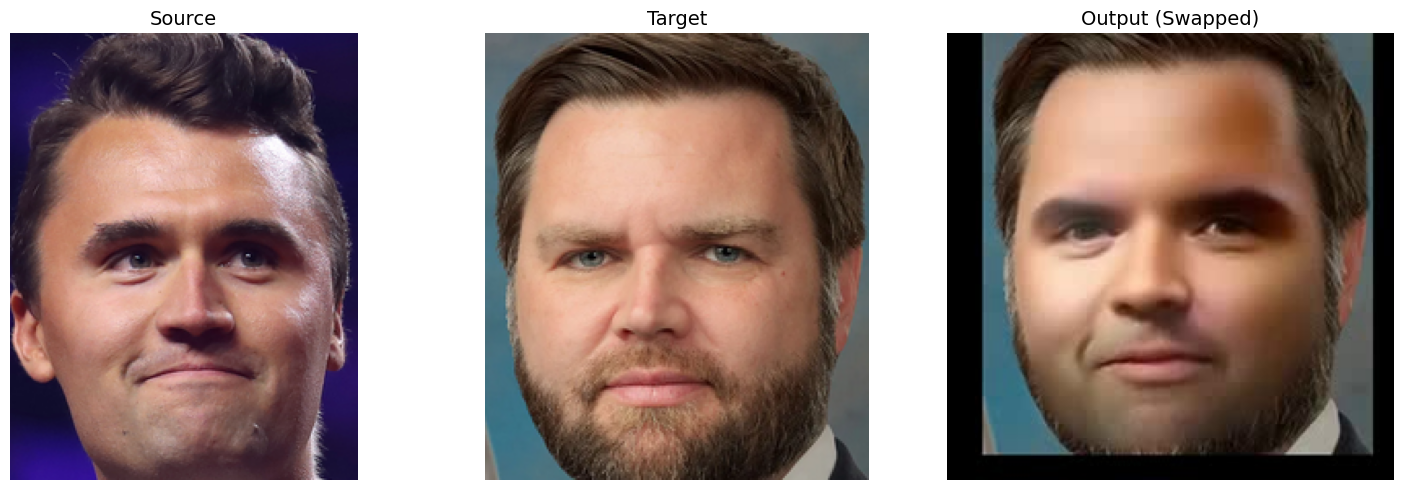

In [110]:

import matplotlib.pyplot as plt
import cv2



# Charger les images
source_img = cv2.imread(source_path)
target_img = cv2.imread(target_path)
output_img = cv2.imread(output_path)

# Convertir BGR en RGB pour matplotlib
source_img = cv2.cvtColor(source_img, cv2.COLOR_BGR2RGB)
target_img = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)
output_img = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)

# Créer une figure avec 3 sous-graphiques
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Afficher les images
axes[0].imshow(source_img)
axes[0].set_title('Source', fontsize=14)
axes[0].axis('off')

axes[1].imshow(target_img)
axes[1].set_title('Target', fontsize=14)
axes[1].axis('off')

axes[2].imshow(output_img)
axes[2].set_title('Output (Swapped)', fontsize=14)
axes[2].axis('off')

plt.tight_layout()
plt.show()

Derniers conseils :
- Si tu veux éviter le finetune (plus rapide), initialise FaceSwapping avec `finetune=False`.
- Si tu manques de VRAM, réduis `batch_size` et `seg_batch_size`.
- Pour connaître l'appel exact à faire en Python, ouvre `fsgan/inference/swap.py` et cherche la méthode publique (ex: `swap`, `run` ou `inference`).

Si tu veux, je peux maintenant :
- t'ajuster ce notebook pour qu'il appelle directement la méthode exacte d'inférence si tu m'indiques le contenu (ou le chemin) de `fsgan/inference/swap.py` sur ta machine, ou
- générer une version qui lance le CLI du dépôt si tu confirmes le nom du script (par ex `face_swap.py`).